In [262]:
import sys
import os
import shutil
from pathlib import Path
import cv2
import matplotlib.pyplot as plt
import PIL
import torch
import torchvision
from facenet_pytorch import MTCNN, InceptionResnetV1
from torch.ao.nn.quantized.functional import threshold
from torchvision.utils import make_grid
from IPython.display import Video
from torchvision.transforms.v2.functional import to_pil_image
from torchvision.io import read_image
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader
from PIL import Image

In [263]:
if torch.cuda .is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print(device)

mps


In [264]:
print("Python:", sys.version)
cache_dir = torch.hub.get_dir()
print("Torch hub dir:", cache_dir)

cache_path = Path(cache_dir)

print("\nSearching for inception_resnet_v1 weights...")
matches = list(cache_path.rglob("inception_resnet_v1*"))
for m in matches:
    print(m, " size:", m.stat().st_size, "bytes")

if not matches:
    print("No inception_resnet_v1 files found in", cache_path)


Python: 3.11.13 (main, Jun  5 2025, 08:14:07) [Clang 14.0.6 ]
Torch hub dir: /Users/mac/.cache/torch/hub

Searching for inception_resnet_v1 weights...
No inception_resnet_v1 files found in /Users/mac/.cache/torch/hub


In [265]:
curr_work_dir = Path.cwd()
print(curr_work_dir)

/Users/mac/Mtcnn


In [266]:
video_dir = Path("data_video")
video_name = "pat_morgan.mp4"
video_path = video_dir / video_name
print(video_path)

data_video/pat_morgan.mp4


In [267]:
Video(video_path, embed=True)
print(video_path.exists())

True


In [268]:
video_capture = cv2.VideoCapture(str(video_path))

if not video_capture.isOpened():
    print("Error: Could not open video file.")
else:
    frame_rate = int(video_capture.get(cv2.CAP_PROP_FPS))
    frame_count = int(video_capture.get(cv2.CAP_PROP_FRAME_COUNT))
    print("Frame rate: ", frame_rate)
    print("Frame count: ", frame_count)


Frame rate:  30
Frame count:  4194


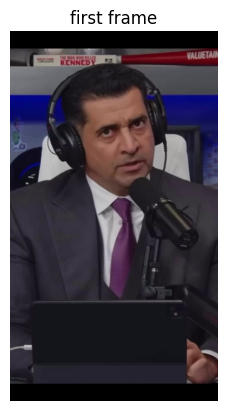

In [269]:
# Reset video pointer to first frame
video_capture.set(cv2.CAP_PROP_POS_FRAMES, 0)

success, first_frame = video_capture.read()
if success:
    plt.imshow(cv2.cvtColor(first_frame, cv2.COLOR_BGR2RGB))
    plt.title("first frame")
    plt.axis("off")
    plt.show()
else:
    print("Error: Could not read first frame.")
video_capture.release()


In [270]:
frames_dir = video_dir / "extracted_frames"
frames_dir.mkdir(exist_ok=True)

In [271]:
frame_count = 0

while True:
    success, frame = video_capture.read()
    if not success:
        break
    # save frames at the frame_rate
    if frame_count % 20 == 0:
        frame_path = frames_dir / f"frame_{frame_count}.jpg"
        cv2.imwrite(frame_path, frame)
    frame_count += 1
video_capture.release()

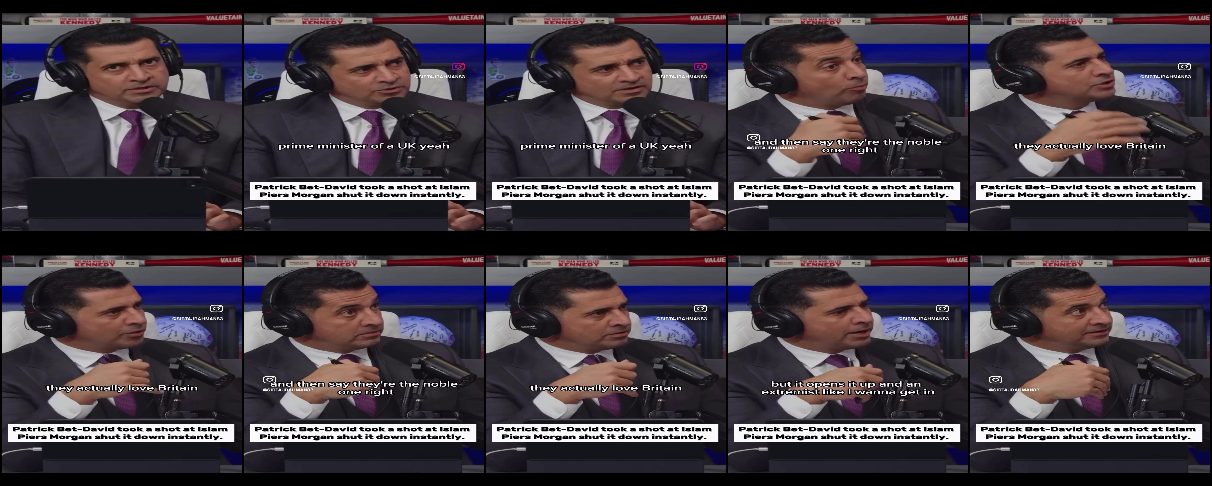

In [272]:
def display_sample_images (dir_path, sample=5) :
    image_list = []
    images = sorted(dir_path.iterdir())
    if images:
        sample_images = images [: sample]
        for sample_image in sample_images:
            image = read_image(str (sample_image))
            # Define resizing transformation that resizes to 240 x 240
            resize_transform = transforms. Resize((240, 240))
            # Resize image by using resize_transform
            image = resize_transform(image)
            image_list. append (image)
    grid = make_grid (image_list, nrow=5)
    image = to_pil_image(grid)
    return image
display_sample_images(frames_dir, sample=10)

In [273]:
images_dir = curr_work_dir / "data_images"
images_dir.mkdir(exist_ok=True)

morgan_dir = images_dir / "morgan"
morgan_dir.mkdir(exist_ok=True)
print(morgan_dir)

/Users/mac/Mtcnn/data_images/morgan


In [274]:
morgan_imgs = [
    "frame_60.jpg",
    "frame_70.jpg",
    "frame_80.jpg",
    "frame_90.jpg",
    "frame_150.jpg",
    "frame_180.jpg",
    "frame_190.jpg",
    "frame_200.jpg",
]
morgan_imgs_path = [frames_dir / img for img in morgan_imgs]
morgan_imgs_path

[PosixPath('data_video/extracted_frames/frame_60.jpg'),
 PosixPath('data_video/extracted_frames/frame_70.jpg'),
 PosixPath('data_video/extracted_frames/frame_80.jpg'),
 PosixPath('data_video/extracted_frames/frame_90.jpg'),
 PosixPath('data_video/extracted_frames/frame_150.jpg'),
 PosixPath('data_video/extracted_frames/frame_180.jpg'),
 PosixPath('data_video/extracted_frames/frame_190.jpg'),
 PosixPath('data_video/extracted_frames/frame_200.jpg')]

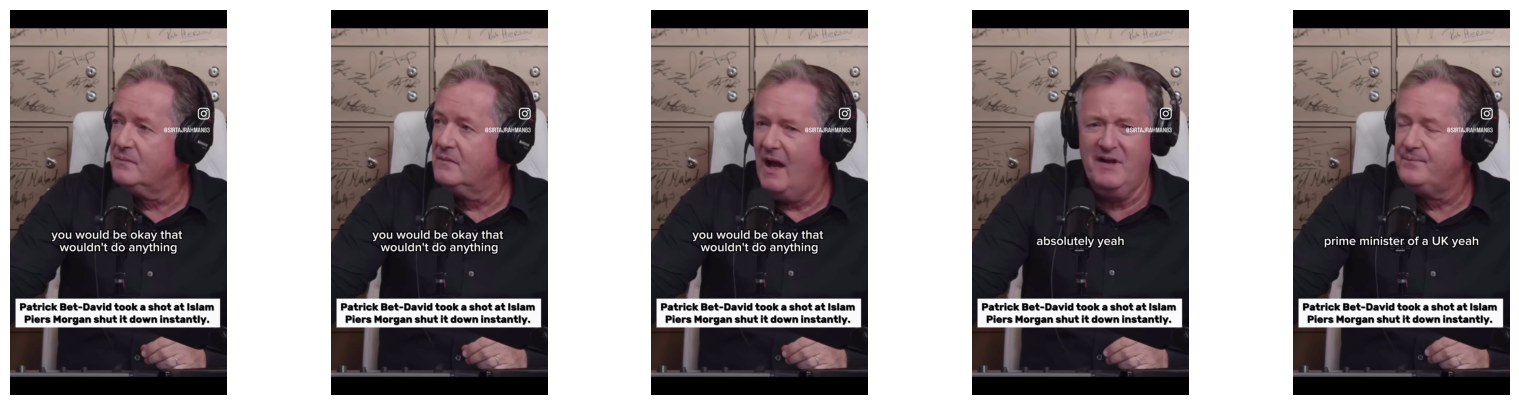

In [275]:
fig, axs = plt.subplots(1, 5, figsize=(20, 5))
for i, ax in enumerate(axs):
    ax.imshow(Image.open(morgan_imgs_path[i]))
    ax.axis("off")


In [276]:
for image_path in morgan_imgs_path:
    shutil.copy(image_path, morgan_dir)

In [277]:
patrick_dir = images_dir / "patrick"
patrick_dir.mkdir(exist_ok=True)
patrick_imgs = [
    "frame_0.jpg",
    "frame_10.jpg",
    "frame_20.jpg",
    "frame_30.jpg",
    "frame_130.jpg",
    "frame_140.jpg",
    "frame_180.jpg",
]
patrick_imgs_path = [frames_dir / img for img in patrick_imgs]
patrick_imgs_path

[PosixPath('data_video/extracted_frames/frame_0.jpg'),
 PosixPath('data_video/extracted_frames/frame_10.jpg'),
 PosixPath('data_video/extracted_frames/frame_20.jpg'),
 PosixPath('data_video/extracted_frames/frame_30.jpg'),
 PosixPath('data_video/extracted_frames/frame_130.jpg'),
 PosixPath('data_video/extracted_frames/frame_140.jpg'),
 PosixPath('data_video/extracted_frames/frame_180.jpg')]

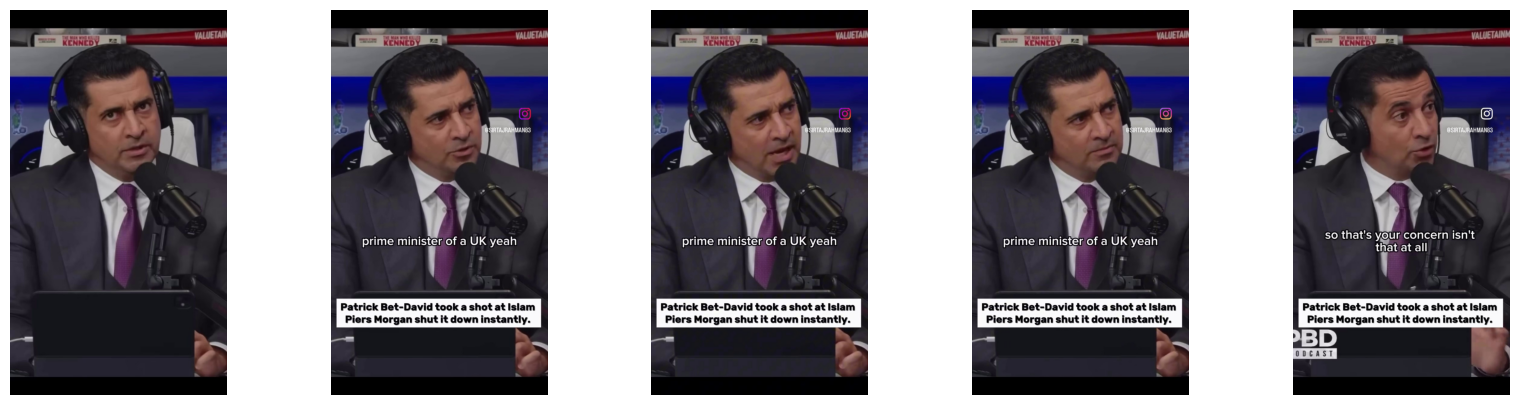

In [278]:
fig, axs = plt.subplots(1, 5, figsize=(20, 5))
for i, ax in enumerate(axs):
    ax.imshow(Image.open(patrick_imgs_path[i]))
    ax.axis("off")

for image_path in patrick_imgs_path:
  shutil.copy(image_path, patrick_dir)

In [279]:
images_folder = Path("data_images")
print(images_folder)
dataset = datasets.ImageFolder(root=images_folder)
print(dataset)
for directory in images_folder.iterdir():
    print(directory)

data_images
Dataset ImageFolder
    Number of datapoints: 15
    Root location: data_images
data_images/patrick
data_images/morgan


In [280]:
dataset.class_to_idx

idx_to_class = {i: c for c, i in dataset.class_to_idx.items()}
print(idx_to_class)
def collate_fn(x):
    return x[0]

{0: 'morgan', 1: 'patrick'}


In [281]:
loader = DataLoader(dataset, collate_fn=collate_fn)
print(loader.dataset)
img, _ = iter(loader).__next__()
# img

Dataset ImageFolder
    Number of datapoints: 15
    Root location: data_images


In [282]:
# initialize mtcnn0 that detects only one face and inception resnet for facial recognition
mtcnn = MTCNN(device="cpu", keep_all=True, min_face_size=60, post_process=True)

# initialize mtcnn0 that detects only one face and inception resnet for facial recognition
mtcnn0 = MTCNN(keep_all=False, device="cpu", min_face_size=40, post_process=True)

# resnet = InceptionResnetV1(pretrained="vggface2").eval()
path = "/Users/mac/.cache/torch/checkpoints/20180402-114759-vggface2.pt"
resnet = InceptionResnetV1(pretrained=None).eval()
state = torch.load(path, map_location="cpu")
state.pop("logits.weight", None)
state.pop("logits.bias", None)
resnet.load_state_dict(state, strict=False)

<All keys matched successfully>

In [283]:
face, prob = mtcnn0(img, return_prob=True)
print(type(face))
print(f"Probability of detected face: {prob}")
face_4d = face.unsqueeze(0)
print(face_4d.shape)

<class 'torch.Tensor'>
Probability of detected face: 0.9999771118164062
torch.Size([1, 3, 160, 160])


In [284]:
embeddings = resnet(face_4d)
print(f"Embedding shape: {embeddings.shape}")

name_to_embeddings = {name: [] for name in idx_to_class.values()}

for img, idx in loader:
    face, prob = mtcnn0(img, return_prob=True)
    if face is not None and prob >= 0.9:
        emb = resnet(face.unsqueeze(0))
        name_to_embeddings[idx_to_class[idx]].append(emb)

print(name_to_embeddings.keys())
print(type(name_to_embeddings["morgan"]))

morgan_embs = torch.stack(name_to_embeddings["morgan"])
patrick_embs = torch.stack(name_to_embeddings["patrick"])
print(morgan_embs.shape)
print(patrick_embs.shape)

avg_morgan_embs = torch.mean(morgan_embs, dim=0)
avg_patrick_embs = torch.mean(patrick_embs, dim=0)
print(avg_morgan_embs.shape)
print(avg_patrick_embs.shape)

embeddings_to_save = [(avg_morgan_embs, "morgan"), (avg_patrick_embs, "patrick")]
torch.save(embeddings_to_save, "embedding.pt")


Embedding shape: torch.Size([1, 512])
dict_keys(['morgan', 'patrick'])
<class 'list'>
torch.Size([8, 1, 512])
torch.Size([7, 1, 512])
torch.Size([1, 512])
torch.Size([1, 512])


In [285]:
# our saved embeddings(faceprints) serve as database, we can take new image and check if the face of morgan or patrick is present(face recognition)
embedding_data = torch.load("embedding.pt")

names = [name for _, name in embedding_data]
print(f" loaded embeddings for: {names}")

 loaded embeddings for: ['morgan', 'patrick']


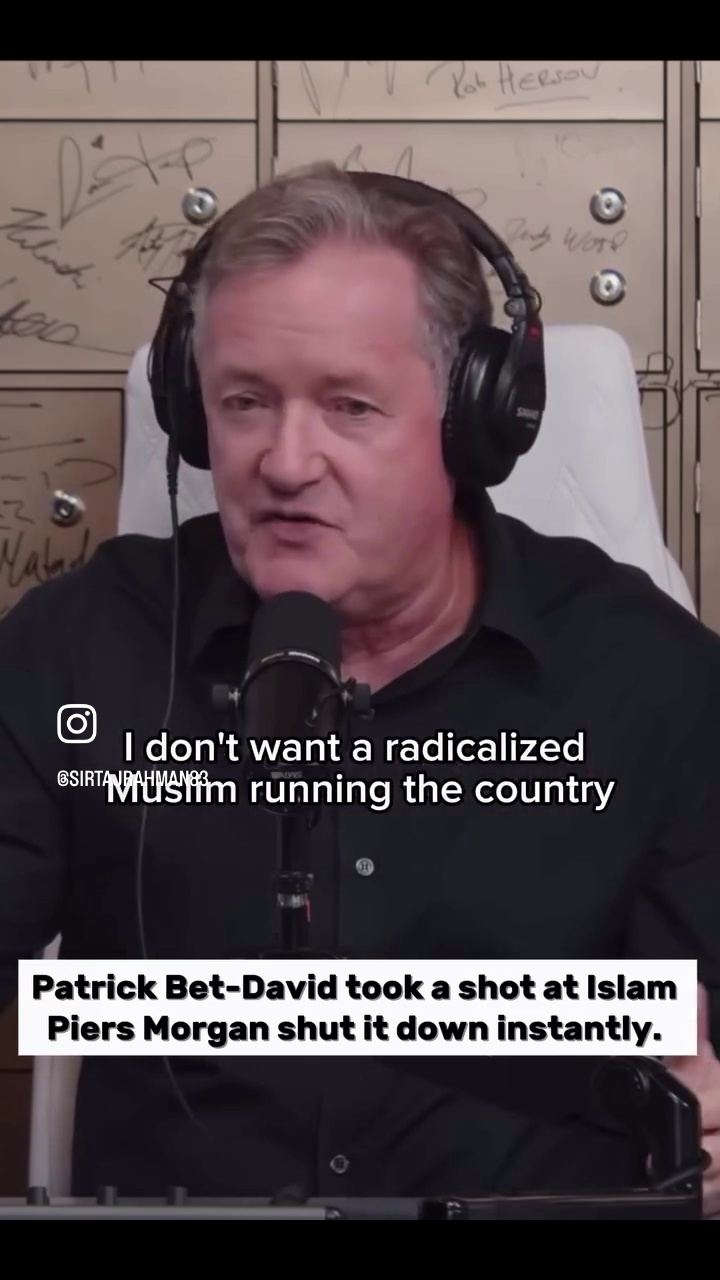

In [286]:
sample_image = "frame_270.jpg"
sample_image_path = frames_dir / sample_image
single_face_image =  Image.open(sample_image_path)

multi_faces_img = "new_combined.jpg"
multi_faces_img_path = curr_work_dir / "multi_faces" / multi_faces_img
multi_faces_image = Image.open(multi_faces_img_path)

single_face_image

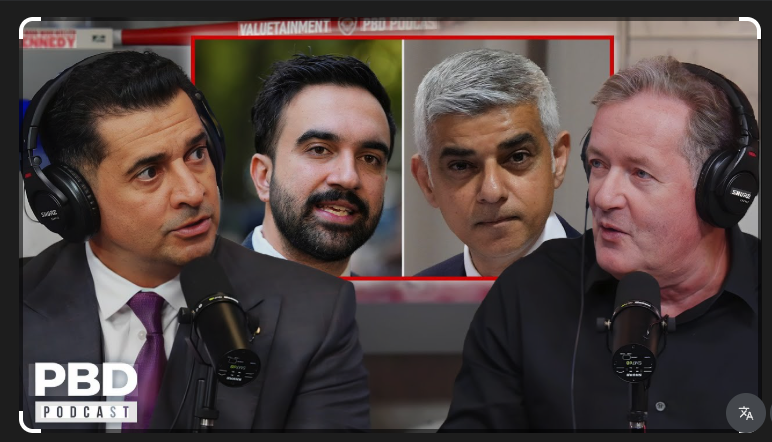

In [287]:
# ResNet on image with more than one face
multi_faces_image

In [288]:
# locate_face
def locate_face(image):
    if image.mode != "RGB":
        image = image.convert("RGB")
    cropped_faces, probs = mtcnn(image, return_prob=True)
    boxes, prob_score, landmarks = mtcnn.detect(image, landmarks=True)
    if boxes is None or cropped_faces is None:
        return []
    else:
        return list(zip(boxes, probs, prob_score, cropped_faces, landmarks))


In [289]:
faces = locate_face(multi_faces_image)
n_of_faces= len(faces)
print(n_of_faces)

4


In [290]:
# explore face data

face1, face2, face3, face4 = faces[0], faces[1], faces[2], faces[3]
box1, prob1, prob_score1, cropped_face1, landmark1 = face1[0], face1[1], face1[2], face1[3], face1[4]

print(f"First face bounding box: {box1}")
print(f"First face bounding box type: {type(box1)}")

print(f"First face Probability: {prob1}")
print(f"First face Probability type: {type(prob1)}")

print(f"First face Probability Score: {prob_score1}")
print(f"First face Probability Score type: {type(prob_score1)}")

print(f"First face cropped face: {cropped_face1.shape}")

print(f"First face landmarks: {landmark1}")

First face bounding box: [ 93.38572  98.37058 223.53738 268.06067]
First face bounding box type: <class 'numpy.ndarray'>
First face Probability: 0.9998847246170044
First face Probability type: <class 'numpy.float32'>
First face Probability Score: 0.9998847246170044
First face Probability Score type: <class 'numpy.float32'>
First face cropped face: torch.Size([3, 160, 160])
First face landmarks: [[148.68195 171.1654 ]
 [197.75063 153.42708]
 [197.93953 196.96985]
 [169.19995 234.60196]
 [210.03339 219.30469]]


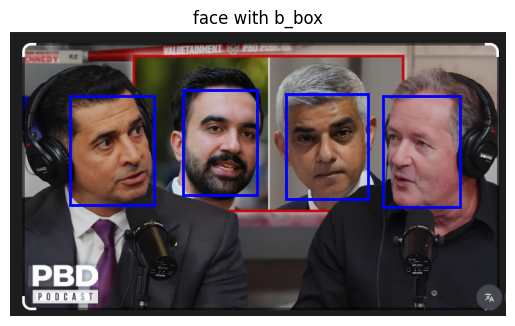

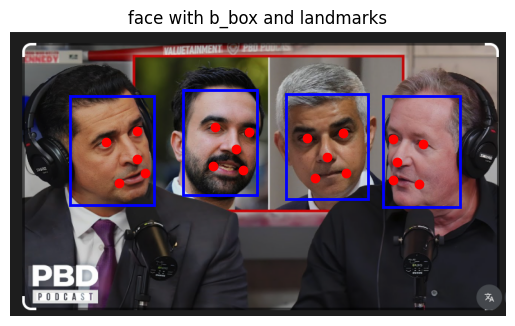

In [291]:
# bounding_boxes

fig, ax = plt.subplots()
ax.imshow(multi_faces_image)
for (box, prob, prob_score, cropped, landmark) in faces:
    b0, b1, b2, b3 = box
    rect = plt.Rectangle(
        (b0, b1), (b2 - b0), (b3 - b1),
        fill=False,
        color="blue",
        linewidth=2
    )
    ax.add_patch(rect)
plt.axis("off");
plt.title("face with b_box");
#
# landmarks
fig, ax = plt.subplots()
ax.imshow(multi_faces_image)
for (box, prob, prob_score, cropped, landmark) in faces:
    b0, b1, b2, b3 = box
    rect = plt.Rectangle(
        (b0, b1), (b2 - b0), (b3 - b1),
        fill=False,
        color="blue",
        linewidth=2
    )
    ax.add_patch(rect)
    for point in landmark:
        ax.plot(point[0], point[1], marker="o", color="red")
plt.axis("off");
plt.title("face with b_box and landmarks");

In [292]:
def determine_name_dist(cropped_face, threshold=0.9):
    emb = resnet(cropped_face.unsqueeze(0))
    distances = []
    for known_emb, name in embedding_data:
        dist = torch.dist(emb, known_emb).item()
        distances.append((dist, name))

    dist, closest = min(distances)
    if dist  < threshold:
        name = closest
    else:
        name = "Unrecognized"
    return name, dist

In [293]:
for idx, face in enumerate(faces):
    name, dist = determine_name_dist(face[3])
    print(f"{idx}: ({name}, {dist})")

0: (patrick, 0.311161607503891)
1: (Unrecognized, 1.1074564456939697)
2: (morgan, 0.4098667800426483)
3: (Unrecognized, 1.333290457725525)


In [294]:
def label_face(name, dist, box, axis):
    rect = plt.Rectangle(
        (box[0], box[1]),
        (box[2] - box[0]),
        (box[3] - box[1]),
        fill=False,
       color="blue"
    )
    axis.add_patch(rect)

    if name == "Unrecognized":
        color="red"
    else:
        color="blue"
    label = f"{name} {dist:.2f}"
    axis.text(box[0], box[1], label, fontsize="large", color=color)

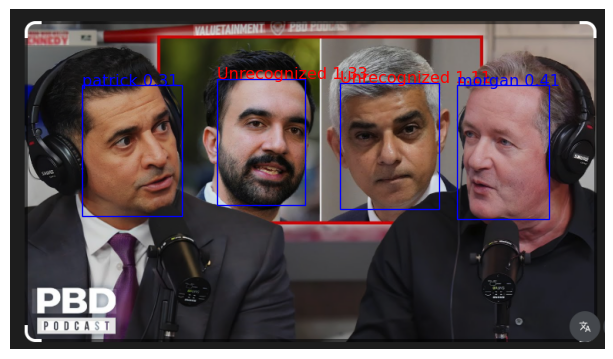

In [295]:
# let's label the boxes with the closest match to the face min distance => threshold = 1.5
width, height = multi_faces_image.size
dpi = 96
fig = plt.figure(figsize=(width / dpi, height / dpi), dpi=dpi)
axis = fig.subplots()
axis.imshow(multi_faces_image)
plt.axis("off")

for face in faces:
    box, prob, prob_score, cropped_face, landmark = face
    name, dist = determine_name_dist(cropped_face)
    label_face(name, dist, box, axis)

In [296]:
def add_labels_to_image(image):
    width, height = image.size
    dpi = 96
    fig = plt.figure(figsize=(width / dpi, height / dpi), dpi=dpi)
    axis = fig.subplots()
    axis.imshow(image)
    plt.axis("off")

    faces = locate_face(image)
    for box, prob, prob_score, cropped_face, landmark in faces:
        if prob < 0.9:
            continue
        name, dist = determine_name_dist(cropped_face)
        label_face(name, dist, box, axis)
    return fig


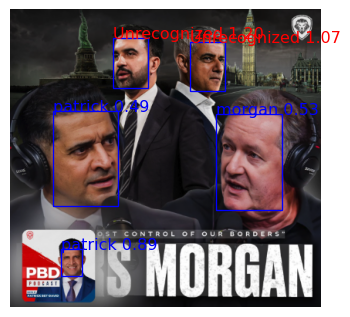

In [297]:
multi_faces_img_path = curr_work_dir / "multi_faces" / "manyfaces.jpg"
multi_faces_image = Image.open(multi_faces_img_path)
labeled_faces = add_labels_to_image(multi_faces_image)

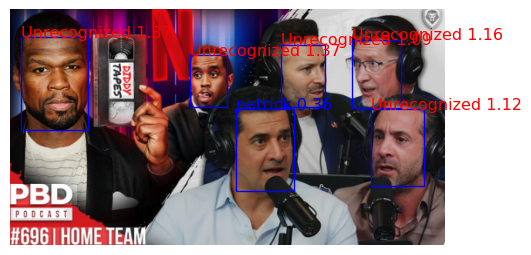

In [298]:
multi_faces_img_path = curr_work_dir / "multi_faces" / "onlypat.jpg"
multi_faces_image = Image.open(multi_faces_img_path)
labeled_faces = add_labels_to_image(multi_faces_image)